In [13]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from pygame import mixer

import os
from IPython.display import display, clear_output

from PIL import Image
import time

In [21]:


# Initialize Pygame Mixer for sound
mixer.init()
sound = mixer.Sound('alarm.wav')  # Path to alarm sound

# Load Haarcascades and Model
face = cv2.CascadeClassifier('C:\\Users\\tejal\\Documents\\prnn\\Drowsiness-Alert-System\\haar cascade files\\haarcascade_frontalface_alt.xml')
leye = cv2.CascadeClassifier('C:\\Users\\tejal\\Documents\\prnn\\Drowsiness-Alert-System\\haar cascade files\\haarcascade_lefteye_2splits.xml')
reye = cv2.CascadeClassifier('C:\\Users\\tejal\\Documents\\prnn\\Drowsiness-Alert-System\\haar cascade files\\haarcascade_righteye_2splits.xml')
model = load_model('C:\\Users\\tejal\\Documents\\prnn\\Drowsiness-Alert-System\\models\\cnnCat2.h5')  # Path to CNN model C:\Users\tejal\Documents\prnn\Drowsiness-Alert-System\models

# Initialize video capture
cap = cv2.VideoCapture(0)

# Variables for drowsiness detection
score = 0
thicc = 2
font = cv2.FONT_HERSHEY_COMPLEX
path = "./"  # Path to save sleepy images

# Function to display frames inline in Jupyter Notebook
def show_frame(frame):
    clear_output(wait=True)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img))



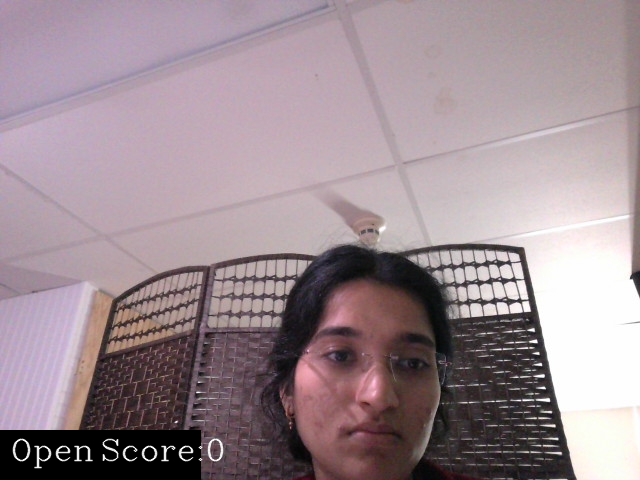

Manual interrupt detected. Exiting loop...


In [20]:
# Main Loop
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        height, width = frame.shape[:2]
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Face and eye detection
        faces = face.detectMultiScale(gray, minNeighbors=5, scaleFactor=1.1, minSize=(25, 25))
        left_eye = leye.detectMultiScale(gray)
        right_eye = reye.detectMultiScale(gray)

        cv2.rectangle(frame, (0, height-50), (200, height), (0, 0, 0), thickness=cv2.FILLED)

        rpred = [1]  # Default prediction for right eye
        lpred = [1]  # Default prediction for left eye

        for (x, y, w, h) in right_eye:
            r_eye = frame[y:y+h, x:x+w]
            r_eye = cv2.cvtColor(r_eye, cv2.COLOR_BGR2GRAY)
            r_eye = cv2.resize(r_eye, (24, 24)) / 255.0
            r_eye = np.expand_dims(r_eye.reshape(24, 24, -1), axis=0)
            rpred = np.argmax(model.predict(r_eye), axis=-1)
            break

        for (x, y, w, h) in left_eye:
            l_eye = frame[y:y+h, x:x+w]
            l_eye = cv2.cvtColor(l_eye, cv2.COLOR_BGR2GRAY)
            l_eye = cv2.resize(l_eye, (24, 24)) / 255.0
            l_eye = np.expand_dims(l_eye.reshape(24, 24, -1), axis=0)
            lpred = np.argmax(model.predict(l_eye), axis=-1)
            break

        # Determine drowsiness state
        if rpred[0] == 0 and lpred[0] == 0:
            score += 1
            cv2.putText(frame, "Closed", (10, height-20), font, 1, (255, 255, 255), 1, cv2.LINE_AA)
        else:
            score -= 1
            cv2.putText(frame, "Open", (10, height-20), font, 1, (255, 255, 255), 1, cv2.LINE_AA)
        
        if score < 0:
            score = 0
        cv2.putText(frame, 'Score:' + str(score), (100, height-20), font, 1, (255, 255, 255), 1, cv2.LINE_AA)

        if score > 15:
            try:
                sound.play()
            except:
                pass
            cv2.rectangle(frame, (0, 0), (width, height), (0, 0, 255), thicc)
            cv2.putText(frame, "DROWSY!", (width//2 - 100, height//2), font, 2, (0, 0, 255), 3)
        
        # Display Frame Inline
        show_frame(frame)
except KeyboardInterrupt:
    print("Manual interrupt detected. Exiting loop...")
finally:
    cap.release()
    cv2.destroyAllWindows()